<a href="https://colab.research.google.com/github/VinishUchiha/Generative-Modeling/blob/master/CGAN/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Jun 23 13:29:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout,Embedding,Concatenate

In [ ]:
def Discriminator(in_shape=(28,28,1), n_classes=10):

  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # scale up to image dimensions with linear activation
  n_nodes = in_shape[0] * in_shape[1]
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((in_shape[0], in_shape[1], 1))(li)
  # image input
  in_image = Input(shape=in_shape)
  # concat label as a channel
  merge = Concatenate()([in_image, li])
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # flatten feature maps
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  # output
  out_layer = Dense(1, activation='sigmoid')(fe)
  # define model
  model = Model([in_image, in_label], out_layer)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
def Generator(latent_dim, n_classes=10):

  in_label = Input(shape=(1,))
  # embedding for categorical input
  li = Embedding(n_classes, 50)(in_label)
  # linear multiplication
  n_nodes = 7 * 7
  li = Dense(n_nodes)(li)
  # reshape to additional channel
  li = Reshape((7, 7, 1))(li)
  # image generator input
  in_lat = Input(shape=(latent_dim,))
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  # merge image gen and label input
  merge = Concatenate()([gen, li])
  # upsample to 14x14
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)
  # upsample to 28x28
  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh' , padding='same')(gen)
  # define model
  model = Model([in_lat, in_label], out_layer)
  return model

In [ ]:
def Gan(g_model, d_model):
  # make weights in the discriminator not trainable
  d_model.trainable = False
  # get noise and label inputs from generator model
  gen_noise, gen_label = g_model.input
  # get image output from the generator model
  gen_output = g_model.output
  # connect image output and label input from generator as inputs to discriminator
  gan_output = d_model([gen_output, gen_label])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_noise, gen_label], gan_output)
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [ ]:
# load fashion mnist images
def load_real_samples():
  # load dataset
  (trainX, trainy), (_, _) = fashion_mnist.load_data()
  # expand to 3d, e.g. add channels
  X = np.expand_dims(trainX, axis=-1)
  # convert from ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return [X, trainy]

In [ ]:
#select real samples
def generate_real_samples(dataset, n_samples):
  # split into images and labels
  images, labels = dataset
  # choose random instances
  ix = np.random.randint(0, images.shape[0], n_samples)
  # select images and labels
  X, labels = images[ix], labels[ix]
  # generate class labels
  y = np.ones((n_samples, 1))
  return [X, labels], y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  # generate points in latent space
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, labels_input])
  # create class labels
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
  bat_per_epo = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      
      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      # update discriminator model weights
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator model weights
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      # prepare points in latent space as input for the generator
      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator ✬ s error
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
      # summarize loss on this batch
      print( 'Epoch: %d, Batch: %d of %d, d1=%.3f, d2=%.3f g=%.3f' %
      (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  # save the generator model
  g_model.save('cgan_generator.h5')

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = Discriminator()
# create the generator
g_model = Generator(latent_dim)
# create the gan
gan_model = Gan(g_model, d_model)
# load image data
dataset = load_real_samples()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Epoch: 90, Batch: 399 of 468, d1=0.695, d2=0.677 g=0.734
Epoch: 90, Batch: 400 of 468, d1=0.656, d2=0.677 g=0.763
Epoch: 90, Batch: 401 of 468, d1=0.704, d2=0.677 g=0.732
Epoch: 90, Batch: 402 of 468, d1=0.675, d2=0.657 g=0.751
Epoch: 90, Batch: 403 of 468, d1=0.706, d2=0.688 g=0.732
Epoch: 90, Batch: 404 of 468, d1=0.692, d2=0.702 g=0.754
Epoch: 90, Batch: 405 of 468, d1=0.710, d2=0.698 g=0.748
Epoch: 90, Batch: 406 of 468, d1=0.699, d2=0.679 g=0.728
Epoch: 90, Batch: 407 of 468, d1=0.677, d2=0.687 g=0.741
Epoch: 90, Batch: 408 of 468, d1=0.688, d2=0.691 g=0.741
Epoch: 90, Batch: 409 of 468, d1=0.714, d2=0.659 g=0.724
Epoch: 90, Batch: 410 of 468, d1=0.682, d2=0.661 g=0.730
Epoch: 90, Batch: 411 of 468, d1=0.705, d2=0.697 g=0.739
Epoch: 90, Batch: 412 of 468, d1=0.706, d2=0.696 g=0.712
Epoch: 90, Batch: 413 of 468, d1=0.674, d2=0.719 g=0.726
Epoch: 90, Batch: 414 of 468, d1=0.734, d2=0.664 g=0.732
Epoch: 90, Batch: 415 of 468, d1=0.668, d2=0.680 g=0.748
Epoch: 90, Batch: 416 of 468, d

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
  # generate points in the latent space
  x_input = np.random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

In [ ]:
# create and save a plot of generated images
def save_plot(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
  plt.show()

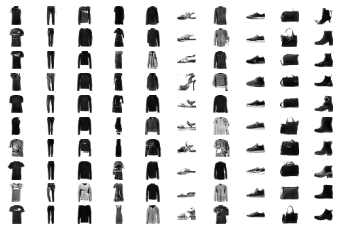

In [ ]:
# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)